# GAN - generating fake handwritten digits

In [1]:
from tensorflow.keras.datasets import mnist
(xtrain,ytrain),(xtest,ytest) = mnist.load_data()
print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


### Generator Model

In [2]:
from tensorflow.keras import models,layers

In [3]:
# Generator
gen_input = layers.Input(shape=(100,),name='generator_input')
x = layers.Dense(128*7*7,activation='tanh')(gen_input)
x = layers.BatchNormalization()(x)
x = layers.Reshape((7,7,128))(x)

x = layers.UpSampling2D()(x)
x = layers.Conv2D(64,(5,5),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='tanh')(x)

x = layers.UpSampling2D()(x)
x = layers.Conv2D(128,(5,5),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='tanh')(x)

gen_op = layers.Conv2D(1,(5,5),activation='tanh',padding='same',name='generator_output')(x)

gen_model = models.Model(gen_input,gen_op,name='generator')
gen_model.compile(loss='binary_crossentropy',optimizer='adam')
gen_model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        25

### Discriminator Model

In [4]:
# Discriminator model
dis_input = layers.Input(shape=(28,28,1),name='discriminator_input')

x = layers.Conv2D(64,(5,5),padding='same')(dis_input)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128,(5,5),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)

dis_op = layers.Dense(1,activation='sigmoid',name='discriminator_output')(x)

dis_model = models.Model(dis_input,dis_op,name='discriminator')
dis_model.compile(loss='binary_crossentropy',optimizer='adam')

dis_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 128)     

In [5]:
# creating a GAN model
dis_model.trainable = False

gan_input = layers.Input(shape=(100,))
x = gen_model(gan_input)
gan_output = dis_model(x)

gan = models.Model(gan_input,gan_output)
gan.compile(loss='binary_crossentropy',optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
generator (Functional)       (None, 28, 28, 1)         1072321   
_________________________________________________________________
discriminator (Functional)   (None, 1)                 213633    
Total params: 1,285,954
Trainable params: 1,059,393
Non-trainable params: 226,561
_________________________________________________________________


In [6]:
xtrain.shape,xtest.shape

((60000, 28, 28), (10000, 28, 28))

In [7]:
xtrain = xtrain.reshape(60000,28,28,1)
xtest = xtest.reshape(10000,28,28,1)

In [8]:
xtrain = (xtrain - 127.5)/127.5
xtest = (xtest - 127.5)/127.5

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
epochs = 20
batch_size = 100
batch_counts = xtrain.shape[0]/batch_size


for i in range(epochs):
  loss = []
  for j in range(int(batch_counts)):
    # step 1 - train discriminator
    # step 2 - train generators

    # Step 1 - train discriminator
    # feed noise to generator to get fake images
    # label fake images as 0
    # load real images, label real images as 1
    # combine both
    # train dis, update parameters of dis
    noise_input = np.random.rand(batch_size,100)
    # getting predictions from generator
    gen_pred = gen_model.predict(noise_input,batch_size=batch_size)
    # loading batch_size = 150, 150 random real images
    real_images = xtrain[np.random.randint(0,60000,batch_size)]
    # combining the two - fake and real to create x for discriminator
    xdis = np.concatenate([gen_pred,real_images])
    # creating labels - 0 for fake, 1 for real
    ydis = np.array([0]*batch_size+[1]*batch_size).reshape(-1,1)
    ######################################################################
    ########################## Train the discriminator model##############
    dis_model.trainable = True
    dis_model.train_on_batch(xdis,ydis)

    # Step 2 - train the generator - achivied by trainig the GAN model and keeping discriminator non trainable
    noise_input = np.random.rand(batch_size,100)
    ygen = np.array([1]*batch_size).reshape(-1,1)
    dis_model.trainable = False
    model_loss = gan.train_on_batch(noise_input,ygen)
    loss.append(model_loss)
  print('Epoch - ', i, "  Loss of GAN is ",sum(loss)/len(loss))

Epoch -  0   Loss of GAN is  4.213434473103376
Epoch -  1   Loss of GAN is  2.6751740926651473
Epoch -  2   Loss of GAN is  12.519653651428984
Epoch -  3   Loss of GAN is  4.790466432287928
Epoch -  4   Loss of GAN is  13.891214858846118
Epoch -  5   Loss of GAN is  4.948753514867858
Epoch -  6   Loss of GAN is  5.202219316431232
Epoch -  7   Loss of GAN is  8.029342457760503
Epoch -  8   Loss of GAN is  7.228511672240711
Epoch -  9   Loss of GAN is  6.031135808565645
Epoch -  10   Loss of GAN is  17.868574018478395
Epoch -  11   Loss of GAN is  16.537114156087238
Epoch -  12   Loss of GAN is  16.201140305201214
Epoch -  13   Loss of GAN is  16.075815858840944
Epoch -  14   Loss of GAN is  15.918771114349365
Epoch -  15   Loss of GAN is  15.815136774381001
Epoch -  16   Loss of GAN is  15.698369067509969
Epoch -  17   Loss of GAN is  15.6129052623113
Epoch -  18   Loss of GAN is  15.559041530291239
Epoch -  19   Loss of GAN is  15.476981952985128


In [17]:
noise_input = np.random.rand(50,100)
predictions = gen_model.predict(noise_input)

print(predictions.shape)

(50, 28, 28, 1)


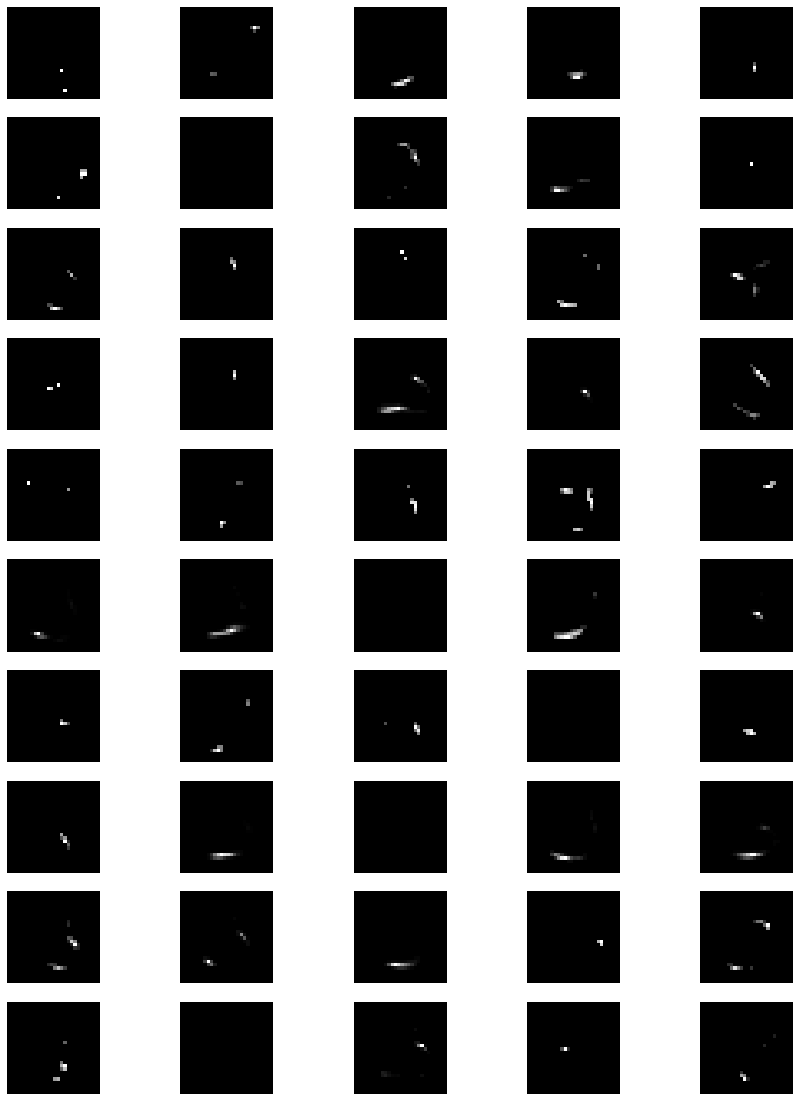

In [18]:
plt.figure(figsize=(15,20))
for i in range(50):
  plt.subplot(10,5,i+1)
  plt.imshow(predictions[i].reshape(28,28),cmap='gray')
  plt.axis('off')
plt.show()
